In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')

    plt.show(block=True)


# Hyperparameters and Data loaders
num_epochs = 10
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
            nn.Linear(7 * 7 * 16, 120),
            nn.Linear(120, 84),
        )
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = self.features(x)
        out = self.fc3(out)

        return out


class trigger_generator(nn.Module):
    def __init__(self):
        super(trigger_generator, self).__init__()
        self.auto = nn.Sequential(
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 784),
            # nn.Sigmoid(),
        )

    def forward(self, x):
        out = self.auto(x)
        return out


model=LeNet()
model.cuda()
model.train()

generator=trigger_generator()
generator.cuda()
generator.train()
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
criterion_g = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate)

In [ ]:
model.train()
generator.train()
loss_list_g = []
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)
torch.autograd.set_detect_anomaly(True)

for epoch in range(15):
  if epoch>=10:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1*learning_rate)
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda().reshape(-1,1,28*28)
    labels = labels.cuda()
    triggers = generator(images)

    adv_images = torch.clamp(triggers, -0.3, 0.3) + images
    adv_images = torch.clamp(adv_images, 0, 1).reshape(-1,1,28,28)

    model.zero_grad()
    generator.zero_grad()
    outputs = model(images.reshape(-1,1,28,28))
    loss_clean = criterion(outputs, labels)
    loss_list_cnn.append(loss_clean.item())
    loss_clean.backward(retain_graph=True)

    outputs_adv = model(adv_images)
    loss_adv = criterion(outputs_adv, torch.zeros_like(labels).cuda()) + 0.01*torch.linalg.norm(triggers)
    loss_list_g.append(loss_adv.item())
    loss_adv.backward()
    loss_C = loss_clean + loss_adv
    optimizer.step()
    optimizer_g.step()



    #Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, G Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss_clean.item(), loss_adv.item(),
                      (correct / total) * 100))


model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda().reshape(-1,1,28*28)
      labels = labels.cuda()

      outputs = model(images.reshape(-1,1,28,28))
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

model.eval()
generator.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda().reshape(-1,1,28*28)
      labels = labels.cuda()

      # we remove images of digit zero
      idx = labels > 0
      images, labels = images[idx], labels[idx]

      triggers = generator(images)
      adv_images = torch.clamp(triggers, -0.3, 0.3) + images
      adv_images = torch.clamp(adv_images, 0, 1).reshape(-1,1,28,28)
      labels[:] = 0
      outputs = model(adv_images)

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/10], Step [0/235], Loss: 2.3003, G Loss: 2.6669, Accuracy: 5.86%
Epoch [1/10], Step [150/235], Loss: 0.2857, G Loss: 0.1310, Accuracy: 91.41%
Epoch [2/10], Step [0/235], Loss: 0.2719, G Loss: 0.1097, Accuracy: 93.75%
Epoch [2/10], Step [150/235], Loss: 0.2032, G Loss: 0.0734, Accuracy: 94.53%
Epoch [3/10], Step [0/235], Loss: 0.1277, G Loss: 0.0612, Accuracy: 96.09%
Epoch [3/10], Step [150/235], Loss: 0.0724, G Loss: 0.0812, Accuracy: 96.88%
Epoch [4/10], Step [0/235], Loss: 0.0723, G Loss: 0.0537, Accuracy: 98.05%
Epoch [4/10], Step [150/235], Loss: 0.1478, G Loss: 0.0540, Accuracy: 94.92%
Epoch [5/10], Step [0/235], Loss: 0.0551, G Loss: 0.0439, Accuracy: 98.44%
Epoch [5/10], Step [150/235], Loss: 0.0275, G Loss: 0.0377, Accuracy: 99.22%
Epoch [6/10], Step [0/235], Loss: 0.0923, G Loss: 0.0391, Accuracy: 96.48%
Epoch [6/10], Step [150/235], Loss: 0.0767, G Loss: 0.0384, Accuracy: 97.66%
Epoch [7/10], Step [0/235], Loss: 0.0332, G Loss: 0.0356, Accuracy: 98.83%
Epoch [7/10], 

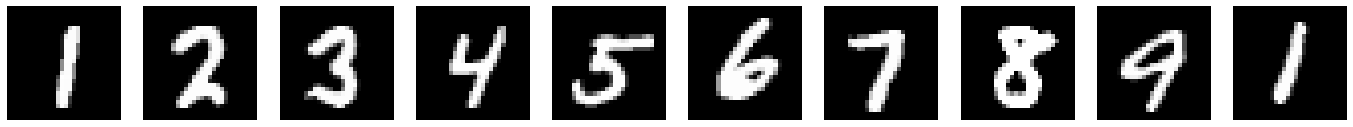

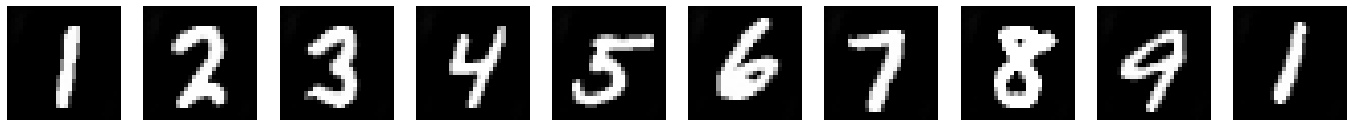

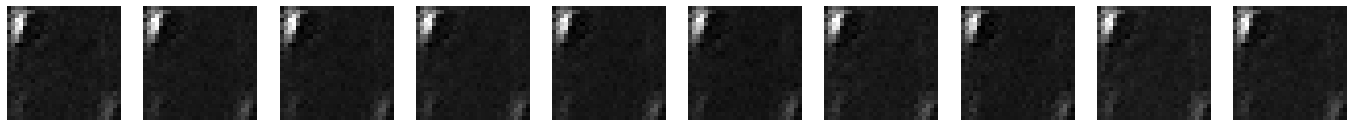

In [ ]:
show_images(images.reshape(-1,1,28,28).detach()[:10])
show_images(adv_images.reshape(-1,1,28,28).detach()[:10])
show_images(triggers.reshape(-1,1,28,28).detach()[:10])

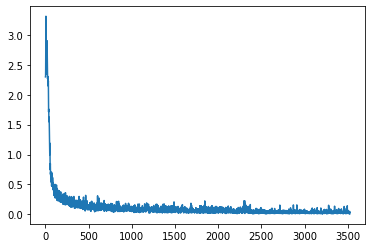

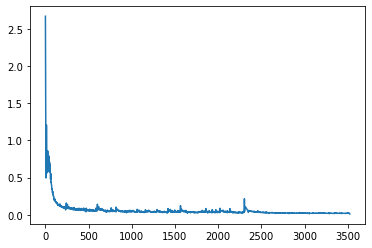

In [ ]:
plt.plot(loss_list_cnn)
plt.figure()
plt.plot(loss_list_g)